In [5]:
import os
import torch
import numpy as np
import time
from math import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import Normalize
import cmcrameri.cm as cmc

%matplotlib inline
plt.style.use('stylesheet.mplstyle')

## Simulate spatially distributed features

In [6]:
# Make a 2D pattern (sine wave to mimic strain features in experimental data)
wave = 0.4
x = y = np.linspace(-1, 1, 64)
X, Y = np.meshgrid(x, y)
gt_strain = 0.0005 * np.sin(2 * np.pi * (X + Y) / wave)

def sigmoid_function(A, x, y, x0, y0, sigma, theta):         
    rot_x = (x-x0)*np.cos(theta) - (y-y0)*np.sin(theta)       
    g = A * (1 / (1 + np.exp(-rot_x/sigma)))
    return g 

# Define the grid coordinates 
x = np.linspace(-3, -1, 64) 
y = np.linspace(-1, 1, 64) 
X, Y = np.meshgrid(x, y)

x1 = np.linspace(-1.5, 0.5, 64)
y1 = np.linspace(-1, 1, 64)
X1, Y1 = np.meshgrid(x1, y1)

x2 = np.linspace(1, 3, 64)
y2 = np.linspace(1, -1, 64)
X2, Y2 = np.meshgrid(x2, y2)

# Create the sigmoid function with adjustable parameters 
lr = sigmoid_function(0.01, X, Y, 0, 0, 0.07, np.pi/3) # rotate by 60 degrees 
lr1 = -sigmoid_function(0.01, X1, Y1, 0, 0, 0.07, np.pi/3)
lr2 = -sigmoid_function(0.01, X2, Y2, 0, 0, 0.07, 2*np.pi/3)
gt_tilt_lr = lr + lr1 + 0.005 + lr2

ud = sigmoid_function(0.015, X, Y, 0, 0, 0.07, np.pi/3) # rotate by 60 degrees 
ud1 = -sigmoid_function(0.015, X1, Y1, 0, 0, 0.07, np.pi/3)
ud2 = -sigmoid_function(0.015, X2, Y2, 0, 0, 0.07, 2*np.pi/3)
gt_tilt_ud = ud + ud1 + 0.0075 + ud2

[]

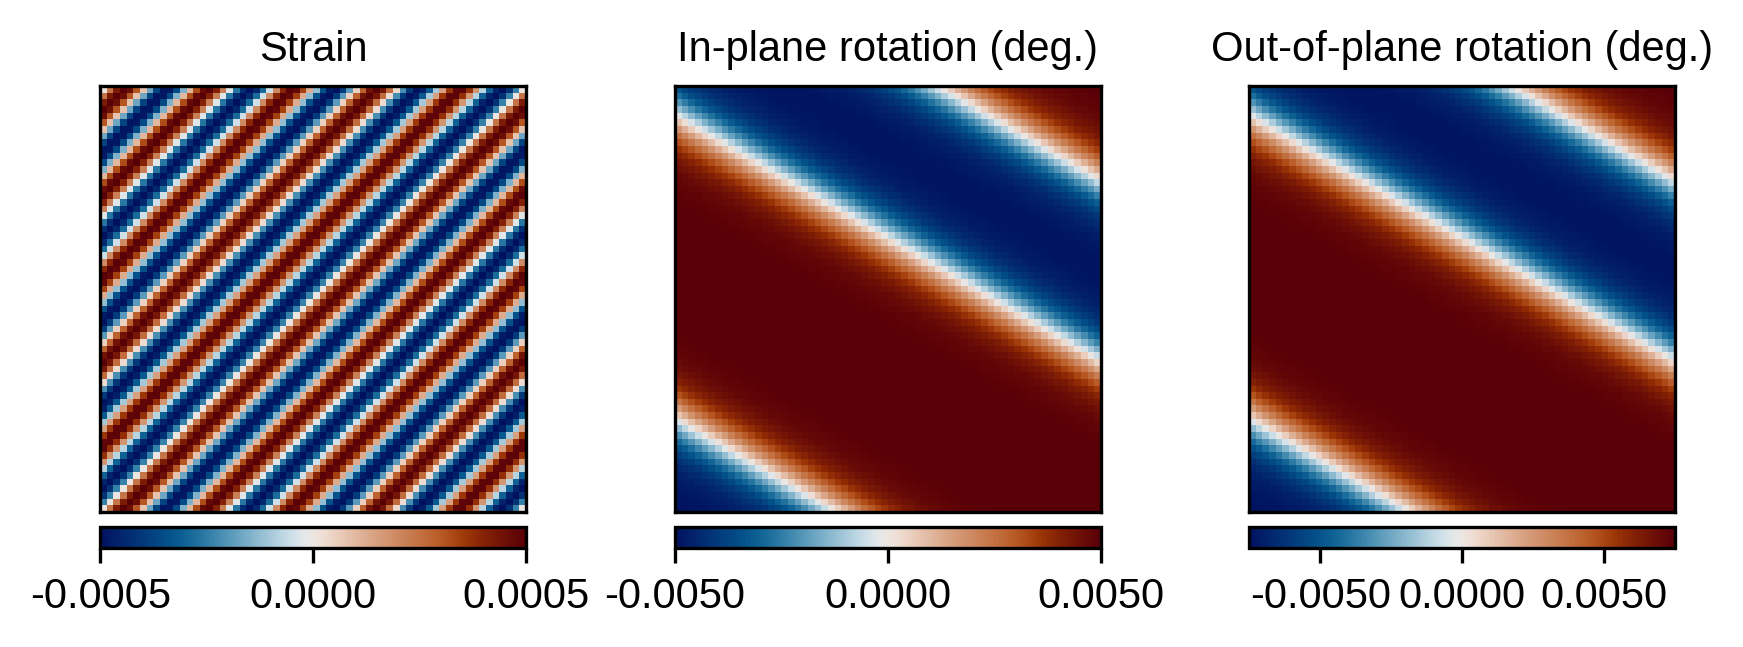

In [9]:
f, ax = plt.subplots(figsize=(7, 2), ncols=3)

vmin0 = -0.0005
vmax0 = 0.0005
vmin1 = -0.005
vmax1 = 0.005
vmin2 = -0.0075
vmax2 = 0.0075

im0 = ax[0].imshow(gt_strain, interpolation='none', vmin=vmin0, vmax=vmax0, cmap=cmc.vik)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal', format='%.4f')
ax[0].set_title('Strain')
ax[0].set_xticks([])
ax[0].set_yticks([])

im1 = ax[1].imshow(gt_tilt_lr, interpolation='none', vmin=vmin1, vmax=vmax1, cmap=cmc.vik)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[1].set_title('In-plane rotation (deg.)')
ax[1].set_xticks([])
ax[1].set_yticks([])

im2 = ax[2].imshow(gt_tilt_ud, interpolation='none', vmin=vmin2, vmax=vmax2, cmap=cmc.vik)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[2].set_title('Out-of-plane rotation (deg.)')
ax[2].set_xticks([])
ax[2].set_yticks([])

## Simulate diffraction for those features

In [2]:
# Simulation construction
oversampling1 = 1

energy = 11.3
wavelength = 12.398/energy
K=2*pi/wavelength
c = 4.013
l = 2
alf0 = asin(wavelength*l/2/c)
alf = alf0 
twotheta = (2 * alf0) 
X0 =  256 
Xcen = 256 

distance = 0.85
pixelsize = 55e-6/oversampling1*2 # The *2 is for binning

gam0 = twotheta-alf

focal_length = 21.874e-3
outer_angle = 149e-6/2/focal_length # diameter of FZP is 150 um
inner_angle = 77e-6/2/focal_length # diameter of CS is 75 um 

precision = 5e-4 # for fast numerical integration

det_x = np.arange(64*oversampling1).astype(np.float64)
det_y = np.arange(64*oversampling1).astype(np.float64)
det_x = det_x - det_x.mean() + X0 - (X0-Xcen)*oversampling1
det_y -= det_y.mean()

det_xx, det_yy = np.meshgrid(det_x,det_y)

gam = np.arcsin((det_xx-X0)*pixelsize/distance)+gam0

#detector
det_Qx = K*(np.cos(alf)-np.cos(gam))
det_Qz = K*(np.sin(gam)+np.sin(alf))
det_Qy = det_yy*pixelsize/distance*K

oversampling2 = 2

O_x = np.arange(64*oversampling2).astype(np.float64)
O_y = np.arange(64*oversampling2).astype(np.float64)
O_x -= O_x.mean()
O_y -= O_y.mean()

O_xx, O_yy = np.meshgrid(O_x,O_y)
O_xx = O_xx[:,:,np.newaxis,np.newaxis]
O_yy = O_yy[:,:,np.newaxis,np.newaxis]

# origin of the reciprocal space
O_Qx = -O_xx*pixelsize*oversampling1/oversampling2/distance*K*sin(alf)
O_Qz = O_xx*pixelsize*oversampling1/oversampling2/distance*K*cos(alf)# the sign of Qx and Qz are opposite in this convention
O_Qy = O_yy*pixelsize*oversampling1/oversampling2/distance*K
O_angle = np.sqrt(O_yy**2+O_xx**2)*pixelsize*oversampling1/oversampling2/distance
O_donut = (O_angle < outer_angle) * (O_angle > inner_angle)

(128, 128, 1, 1)


In [7]:
def Thickness_Fringe(thickness=117, strain=0, tilt_lr=0, tilt_ud=0, precision=5e-4):

    return ((thickness*np.sinc(thickness*(det_Qz-2*pi/c*l/(1+strain)-O_Qz)/pi/2)**2 *\
            (np.abs(det_Qx+2*pi/c*l/(1+strain)*radians(tilt_lr)-O_Qx)<precision) *\
            (np.abs(det_Qy+2*pi/c*l/(1+strain)*radians(tilt_ud)-O_Qy)<precision))*O_donut)\
            .sum(axis=(0,1)).reshape(64,oversampling1,64,oversampling1).mean(axis=(1,3))

In [ ]:
# Only run this cell if you want to generate your own data! 
# The simulation used in the paper is included in the data repository

sim_data = np.zeros((64, 64, 64, 64))

def sim_row(row_num):
    temp = np.zeros((64, 64, 64))
    for i in range(temp.shape[0]):
        temp[i] = Thickness_Fringe(thickness=117, strain=gt_strain[row_num, i], tilt_lr=gt_tilt_lr[row_num, i],
                                   tilt_ud=gt_tilt_ud[row_num, i])
    sim_data[row_num] = temp

t0 = time.time()
Parallel(n_jobs=64, require='sharedmem')(delayed(sim_row)(row_num) for row_num in range(sim_data.shape[0]))

sim_data = np.reshape(sim_data, (sim_data.shape[0]*sim_data.shape[1], sim_data.shape[2], sim_data.shape[3]))
    
sim_data = (sim_data / np.max(sim_data)) * 7

for i in range(sim_data.shape[0]):
    sim_data[i] = np.random.default_rng().poisson(sim_data[i])
sim_data = np.rint(sim_data).astype('float32')

print('Sim. time (min.): ', (time.time()-t0)/60)

folder = '/SOME_PATH/Nanobeam_NN/data'
np.save(os.path.join(folder, 'sim_sample.npy'), sim_data)

In [8]:
folder = '/SOME_PATH/Nanobeam_NN/data'
sim_data = np.load(os.path.join(folder, 'sim_sample.npy'))

## Fit maximum correlation between data and simulated diffraction library

In [ ]:
# Find parameters by fitting
# Only run this cell if you need to fit your own simulated data; it takes a long time!
folder = '/SOME_PATH/Nanobeam_NN/data'
sim_mat = np.load(os.path.join(folder, 'sim_mat.npy'))

sim_mat /= sim_mat.sum(axis=(3, 4), keepdims=True)

fit_strain = np.zeros((sim_data.shape[0], ))
fit_tilt_lr = np.zeros((sim_data.shape[0], ))
fit_tilt_ud = np.zeros((sim_data.shape[0], ))

i = 0
t0 = time.time()

while i + 400 < 4096: # 400 indicates number of points fit per iteration, adjust based on available RAM
    dd = np.copy(sim_data)
    dd_sum = (dd[i:i+400, np.newaxis, np.newaxis, np.newaxis]*sim_mat).sum(axis=(4, 5)) # Correlation matrix

    dd_sum_s = dd_sum.sum(axis=(2, 3))
    dd_sum_s -= dd_sum_s.min(axis=1, keepdims=True)

    dd_sum_lr = dd_sum.sum(axis=(1, 3))
    dd_sum_lr -= dd_sum_lr.min(axis=1, keepdims=True)

    dd_sum_ud = dd_sum.sum(axis=(1, 2))
    dd_sum_ud -= dd_sum_ud.min(axis=1, keepdims=True)

    i_s = (dd_sum_s*np.arange(41)).sum(axis=(1))/dd_sum_s.sum(axis=(1)) # Per parameter weighted sum COM
    s = (i_s-20)*0.00025

    i_lr = (dd_sum_lr*np.arange(41)).sum(axis=(1))/dd_sum_lr.sum(axis=(1))
    lr= (i_lr-20)*0.0025

    i_ud = (dd_sum_ud*np.arange(41)).sum(axis=(1))/dd_sum_ud.sum(axis=(1))
    ud = (i_ud-20)*0.005
    
    fit_strain[i:i+400] = s
    fit_tilt_lr[i:i+400] = lr
    fit_tilt_ud[i:i+400] = ud
    i += 400

dd = np.copy(sim_data)
dd_sum = (dd[i:, np.newaxis, np.newaxis, np.newaxis]*sim_mat).sum(axis=(4, 5))

dd_sum_s = dd_sum.sum(axis=(2, 3))
dd_sum_s -= dd_sum_s.min(axis=1, keepdims=True)

dd_sum_lr = dd_sum.sum(axis=(1, 3))
dd_sum_lr -= dd_sum_lr.min(axis=1, keepdims=True)

dd_sum_ud = dd_sum.sum(axis=(1, 2))
dd_sum_ud -= dd_sum_ud.min(axis=1, keepdims=True)

i_s = (dd_sum_s*np.arange(41)).sum(axis=(1))/dd_sum_s.sum(axis=(1))
s = (i_s-20)*0.00025

i_lr = (dd_sum_lr*np.arange(41)).sum(axis=(1))/dd_sum_lr.sum(axis=(1))
lr = (i_lr-20)*0.0025

i_ud = (dd_sum_ud*np.arange(41)).sum(axis=(1))/dd_sum_ud.sum(axis=(1))
ud = (i_ud-20)*0.005

print('Fit time (min): ', (time.time()-t0)/60)
fit_strain[i:] = s
fit_tilt_lr[i:] = lr
fit_tilt_ud[i:] = ud

np.save(os.path.join(folder, 'strain_fit_sim.npy'), fit_strain)
np.save(os.path.join(folder, 'tilt_lr_fit_sim.npy'), fit_tilt_lr)
np.save(os.path.join(folder, 'tilt_ud_fit_sim.npy'), fit_tilt_ud)

In [9]:
folder = '/SOME_PATH/Nanobeam_NN/data'

fit_strain = np.load(os.path.join(folder, 'strain_fit_sim.npy'))
fit_tilt_lr = np.load(os.path.join(folder, 'tilt_lr_fit_sim.npy'))
fit_tilt_ud = np.load(os.path.join(folder, 'tilt_ud_fit_sim.npy'))

In [10]:
# Network predictions

class DiffDataset(Dataset):
    """Lattice values calculated separately and not passed in here (no labels)."""
    
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data[idx]
        sample = {'image': image}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert numpy arrays to Tensors"""
    def __call__(self, sample):
        image = sample['image']
        return {'image': torch.unsqueeze(torch.from_numpy(image), 0)}
    
diff_dataset = DiffDataset(data=sim_data, transform=ToTensor())
dataloader = DataLoader(diff_dataset, batch_size=64, shuffle=False)

# Convolutional Neural Network

class NanobeamNN(nn.Module):
    def __init__(self):
        super(NanobeamNN, self).__init__()
        
        self.operation = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(4, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.fc1 = nn.Linear(1024, 3)
        
    def forward(self, x):
        x = self.operation(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

cnn = NanobeamNN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
cnn = torch.load('trained_model.pth')

cuda:0


In [11]:
pred = np.zeros((64, 64, 3))

with torch.no_grad():
    for i, sample in enumerate(dataloader):
        images = sample['image'].to(device)
        outputs = cnn(images)
        pred[i] = outputs.detach().cpu().numpy()
        
pred_strain = pred[:, :, 0]/100
pred_tilt_lr = pred[:, :, 1]/10
pred_tilt_ud = pred[:, :, 2]/5

# Compare correlation fitting and NanobeamNN

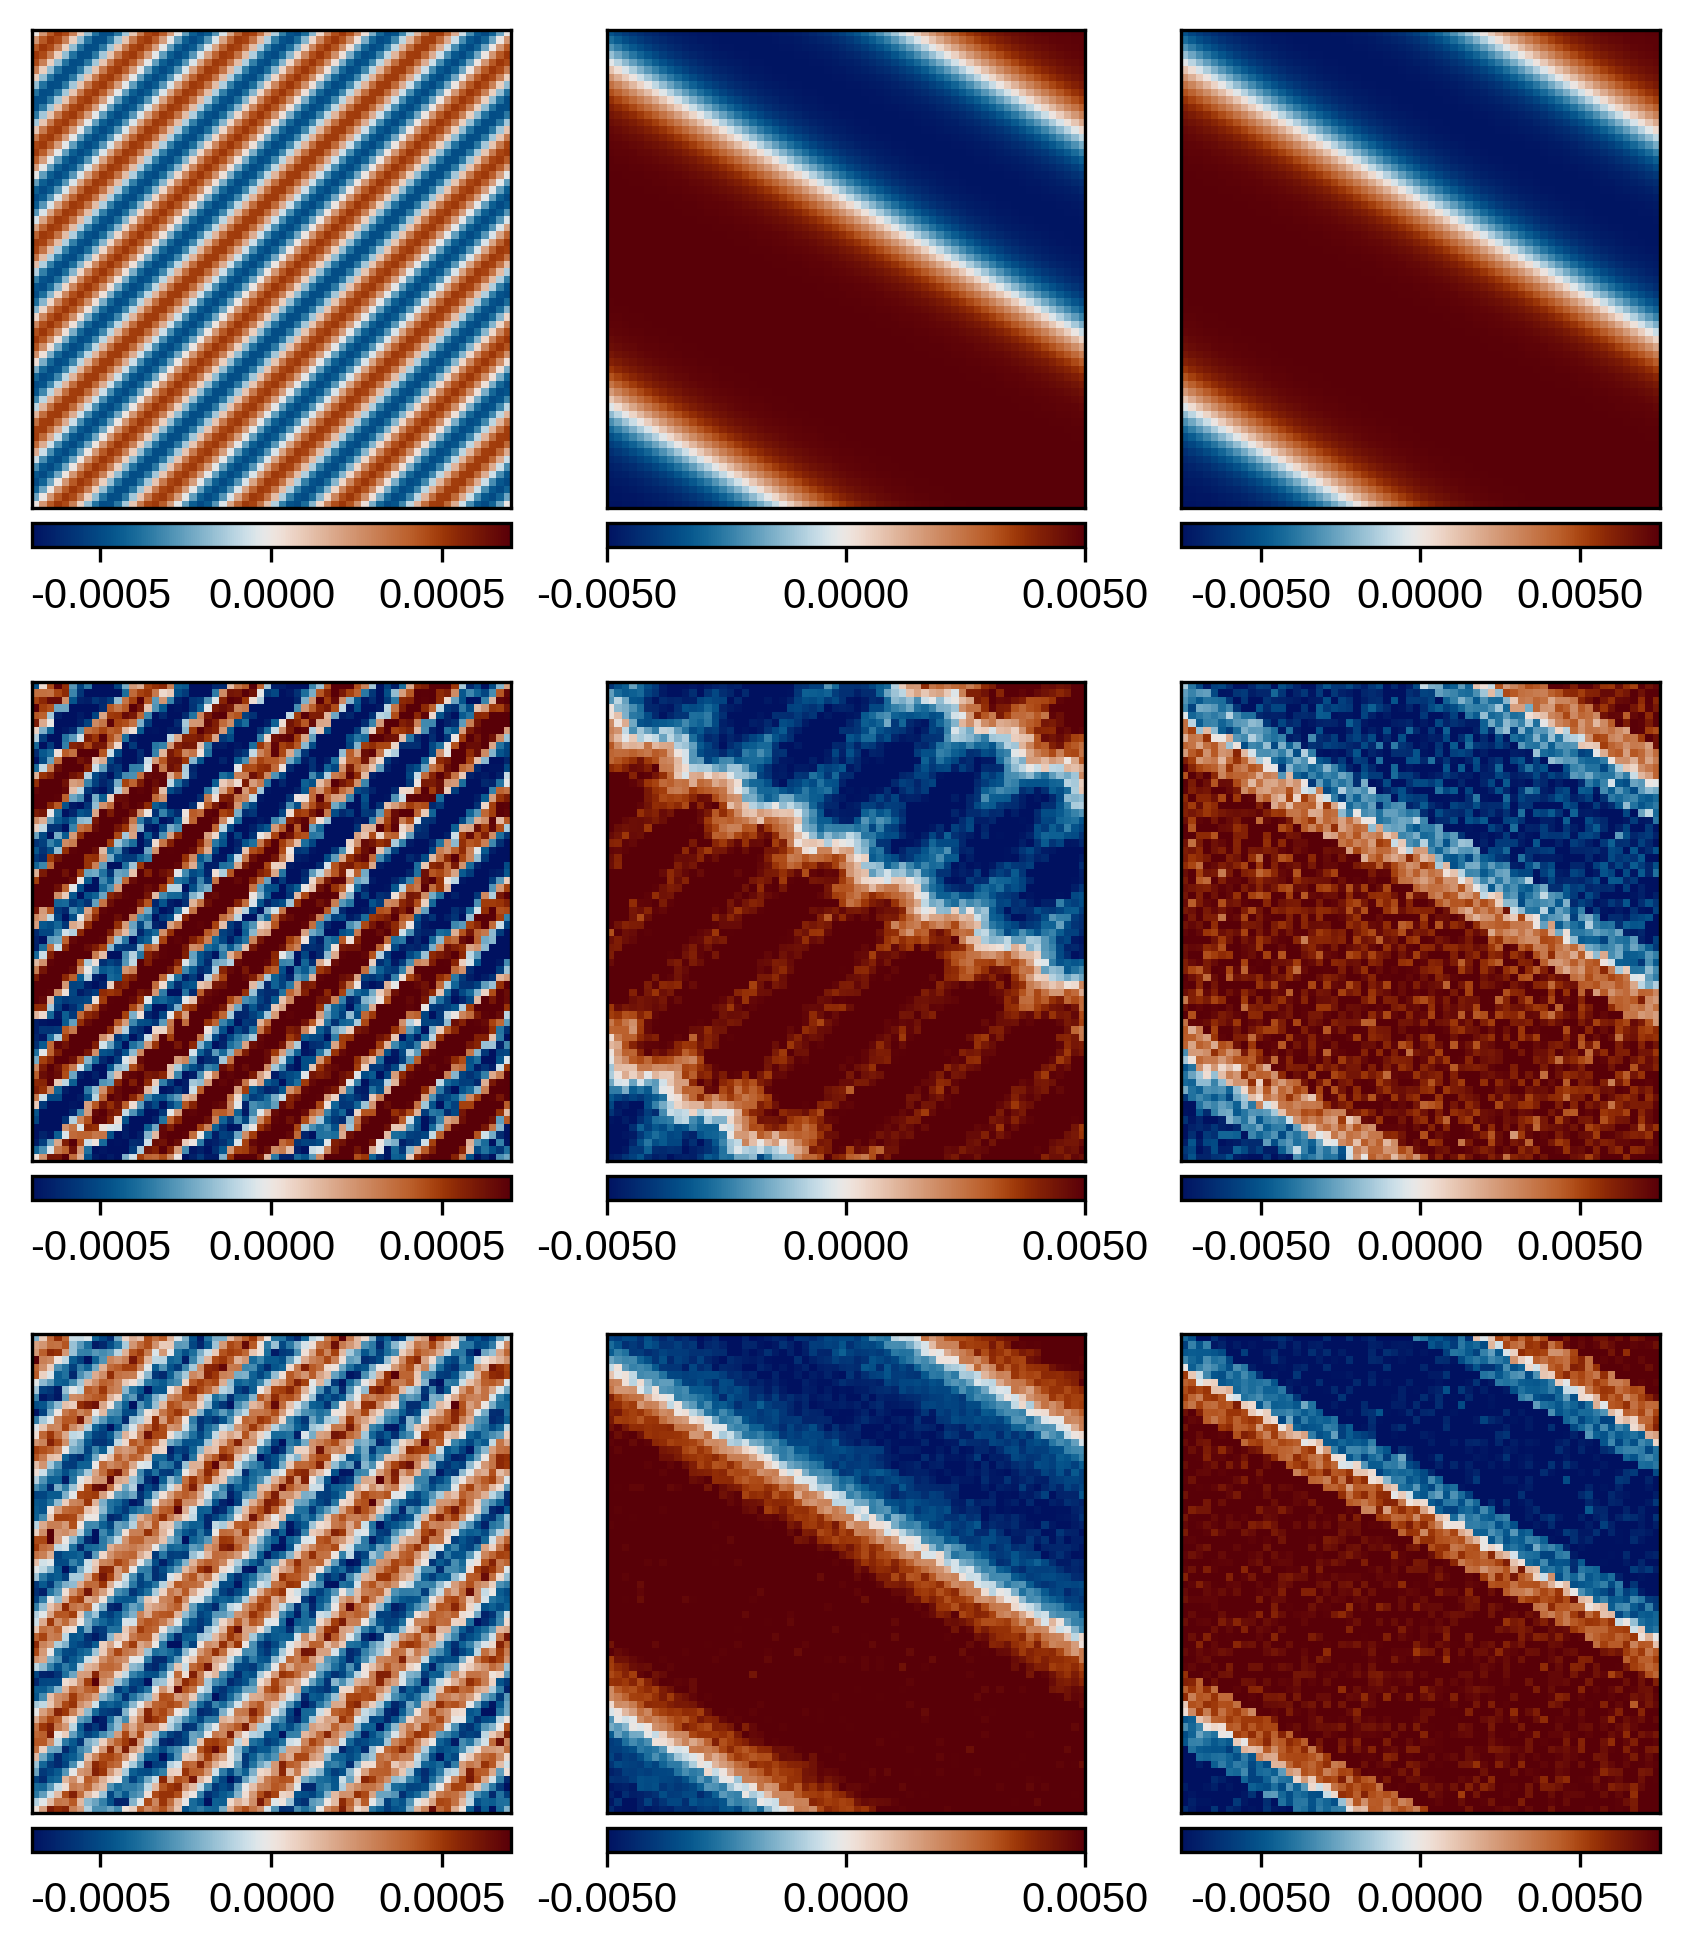

In [14]:
# Refer to Figure 3 of the main text
f, ax = plt.subplots(figsize=(7, 8), nrows=3, ncols=3)

vmin0 = -0.0007
vmax0 = 0.0007
vmin1 = -0.005
vmax1 = 0.005
vmin2 = -0.0075
vmax2 = 0.0075

im0 = ax[0, 0].imshow(gt_strain, interpolation='none', vmin=vmin0, vmax=vmax0, cmap=cmc.vik)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 0].set_title('Strain')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(gt_tilt_lr, interpolation='none', vmin=vmin1, vmax=vmax1, cmap=cmc.vik)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('In-plane rotation (deg.)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(gt_tilt_ud, interpolation='none', vmin=vmin2, vmax=vmax2, cmap=cmc.vik)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 2].set_title('Out-of-plane rotation (deg.)')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

fit_im0 = ax[1, 0].imshow(np.reshape(fit_strain, (64, 64)), interpolation='none', vmin=vmin0, 
                          vmax=vmax0, cmap=cmc.vik)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im0, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 0].set_title('Fit strain')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

fit_im1 = ax[1, 1].imshow(np.reshape(fit_tilt_lr, (64, 64)), interpolation='none', vmin=vmin1, vmax=vmax1, 
                          cmap=cmc.vik)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Fit in-plane rotation')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

fit_im2 = ax[1, 2].imshow(np.reshape(fit_tilt_ud, (64, 64)), interpolation='none', vmin=vmin2, vmax=vmax2, 
                          cmap=cmc.vik)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im2, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 2].set_title('Fit out-of-plane rotation')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred_im0 = ax[2, 0].imshow(pred_strain, interpolation='none', vmin=vmin0, vmax=vmax0, cmap=cmc.vik)
divider = make_axes_locatable(ax[2, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im0, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 0].set_title('Predicted strain')
ax[2, 0].set_xticks([])
ax[2, 0].set_yticks([])

pred_im1 = ax[2, 1].imshow(pred_tilt_lr, interpolation='none', vmin=vmin1, vmax=vmax1, cmap=cmc.vik)
divider = make_axes_locatable(ax[2, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im1, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 1].set_title('Predicted in-plane rotation')
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])

pred_im2 = ax[2, 2].imshow(pred_tilt_ud, interpolation='none', vmin=vmin2, vmax=vmax2, cmap=cmc.vik)
divider = make_axes_locatable(ax[2, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im2, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 2].set_title('Predicted out-of-plane rotation')
ax[2, 2].set_xticks([])
ax[2, 2].set_yticks([])